In [9]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# Exercise 1

In [3]:
(x_data, _), (_, _) = cifar10.load_data()

In [4]:
x_data = x_data.reshape((len(x_data), 32, 32, 3))
x_train, x_temp, _, _ = train_test_split(x_data, x_data, test_size=0.2, random_state=42)
x_val, x_test, _, _ = train_test_split(x_temp, x_temp, test_size=0.5, random_state=42)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# At this point, the representation is (8, 8, 16)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 36s 110ms/step - loss: 0.5923 - val_loss: 0.5712
Epoch 2/10
313/313 [==============================] - 34s 107ms/step - loss: 0.5711 - val_loss: 0.5665
Epoch 3/10
313/313 [==============================] - 34s 108ms/step - loss: 0.5678 - val_loss: 0.5642
Epoch 4/10
313/313 [==============================] - 34s 109ms/step - loss: 0.5661 - val_loss: 0.5635
Epoch 5/10
313/313 [==============================] - 35s 111ms/step - loss: 0.5651 - val_loss: 0.5621
Epoch 6/10
313/313 [==============================] - 34s 109ms/step - loss: 0.5644 - val_loss: 0.5614
Epoch 7/10
313/313 [==============================] - 34s 110ms/step - loss: 0.5637 - val_loss: 0.5612
Epoch 8/10
313/313 [==============================] - 34s 110ms/step - loss: 0.5633 - val_loss: 0.5605
Epoch 9/10
313/313 [==============================] - 34s 109ms/step - loss: 0.5628 - val_loss: 0.5601
Epoch 10/10
313/313 [==============================] - 34s 108ms/step - l

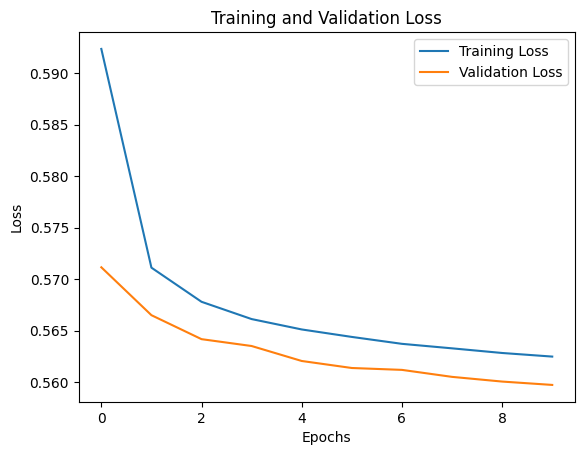

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 [==============================] - 1s 7ms/step


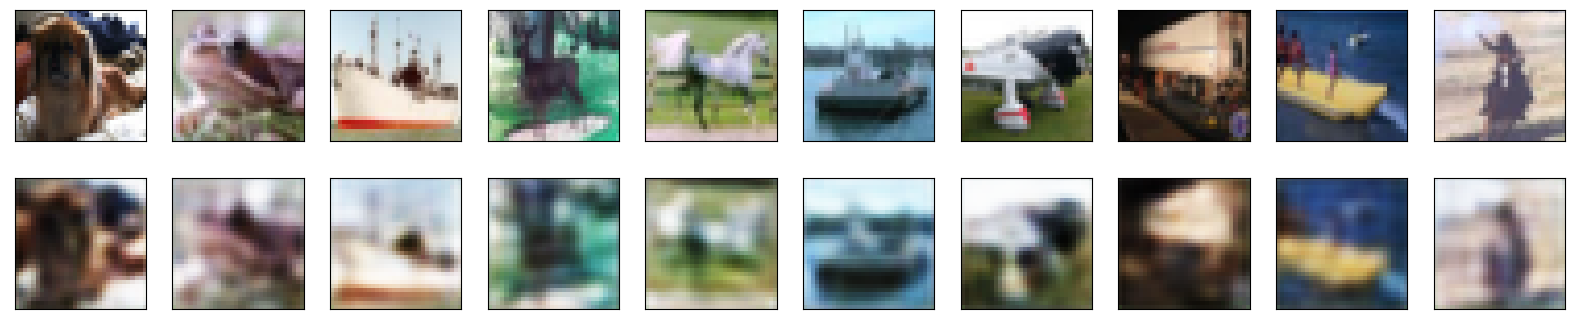

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Exercise 2

In [13]:
layers = [Conv2D, MaxPooling2D, UpSampling2D]

In [38]:

def model_builder(structure, model_params):
    latent_space_sizes = list()
    input_img = Input(shape=(32, 32, 3))
    input_volume = 32
    padding = 1
    ## Set up the first layer
    params = structure[0]["params"]
    x = Conv2D(params[0], params[1], activation=params[3], padding=params[4])(input_img)
    # calculate layer rep. size for first layer
    input_volume = input_volume / params[2]
    latent_space_sizes.append(get_conv_layer_representation_size(input_volume, params[1][0], padding, params[2], params[0]))

    ## set up the remaining layers
    structure = structure[1:]
    for i,layer in enumerate(structure):
        params = layer["params"]
        if layer["layer"] == 0:
            x = Conv2D(params[0], params[1], activation=params[3], padding=params[4])(x)
            input_volume = input_volume / params[2]
            latent_space_sizes.append(get_conv_layer_representation_size(input_volume, params[1][0], padding, params[2], params[0]))

        elif layer["layer"] == 1:
            x = MaxPooling2D(params[0], padding=params[1])(x)
            input_volume = input_volume / params[0][0]
        elif layer["layer"] == 2:
            x = UpSampling2D(params[0])(x)
            input_volume = input_volume * params[0][0]
    

    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=model_params[0], loss=model_params[1])
    return autoencoder, latent_space_sizes

In [43]:
DEBUG = False
def get_conv_layer_representation_size(W, K, P, S, C):
    if (DEBUG):
        print(f"Volume: {W}, kernel size: {K}, padding: {P}, stride:{S}, channels: {C}")
    return ((((W - K + (2*P))/S) + 1)**2) * C

In [29]:
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [44]:
test, latent_space_sizes = model_builder(model_structure, model_params)
print(test.summary())
print(latent_space_sizes)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 8, 8, 16)          174